In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features (e.g., Open, High, Low, Close, Volume)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
spy_data = spy_data[features]
spy_data['Daily_Return'] = spy_data['Close'].pct_change()
spy_data.dropna(inplace=True)

# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)

[*********************100%***********************]  1 of 1 completed

Dataset shape: (3521, 6)
[[ 1.13260002e+02  1.13680000e+02  1.12849998e+02  1.13629997e+02
   1.11579900e+08  2.64709625e-03]
 [ 1.13519997e+02  1.13989998e+02  1.13430000e+02  1.13709999e+02
   1.16074400e+08  7.04055557e-04]
 [ 1.13500000e+02  1.14330002e+02  1.13180000e+02  1.14190002e+02
   1.31091100e+08  4.22129418e-03]
 ...
 [ 4.75440002e+02  4.76660004e+02  4.74890015e+02  4.76510010e+02
   6.80003000e+07  1.80808553e-03]
 [ 4.76880005e+02  4.77549988e+02  4.76260010e+02  4.76690002e+02
   7.71581000e+07  3.77731154e-04]
 [ 4.76489990e+02  4.77029999e+02  4.73299988e+02  4.75309998e+02
   1.22234100e+08 -2.89497341e-03]]


In [48]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    for i in range(len(data) - time_steps):
        # Extract a sequence of `time_steps` (excluding the target column)
        sequence = np.delete(data[i:i + time_steps], target_column, axis=1)
        sequences.append(sequence)

        # Extract the target value at the end of the sequence
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 30
target_column = 5  # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)



Shape of X: (3491, 30, 5)
Shape of y: (3491,)


In [49]:
from sklearn.preprocessing import StandardScaler

# Flatten the data to 2D for normalization
num_samples, time_steps, num_features = X.shape
X_flat = X.reshape(-1, num_features)  # Shape: (samples * time_steps, num_features)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the data
X_standardized_flat = scaler.fit_transform(X_flat)

# Reshape back to the original 3D shape
X_standardized = X_standardized_flat.reshape(num_samples, time_steps, num_features)

print("Shape of X_standardized:", X_standardized.shape)  # (num_samples, time_steps, num_features)

X = X_standardized


Shape of X_standardized: (3491, 30, 5)


In [50]:
from sklearn.model_selection import train_test_split

# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2792, 30, 5)
Shape of X_val: (699, 30, 5)
Shape of y_train: (2792,)
Shape of y_val: (699,)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def create_bidirectional_lstm(input_shape=(30,5), units=64, dropout_rate=0.2):
    
    model = Sequential()

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=input_shape))

    # Dropout for regularization
    model.add(Dropout(dropout_rate))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


Epoch 1/50


/opt/anaconda3/envs/sp500/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106 - mae: 0.0740 - val_loss: 0.0062 - val_mae: 0.0725
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - mae: 0.0351 - val_loss: 0.0027 - val_mae: 0.0497
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0013 - val_mae: 0.0329
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0566e-04 - mae: 0.0198 - val_loss: 1.5777e-04 - val_mae: 0.0094
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4589e-04 - mae: 0.0169 - val_loss: 1.7793e-04 - val_mae: 0.0099
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8037e-04 - mae: 0.0140 - val_loss: 4.7286e-04 - val_mae: 0.0174
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2269e-04 - mae: 0.0127 - val_loss: 1.9516e-04 - val_mae: 0.0112
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9714e-04 - mae: 0.0125 - val_loss: 4.1524e-04 - val_mae: 0.0166
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

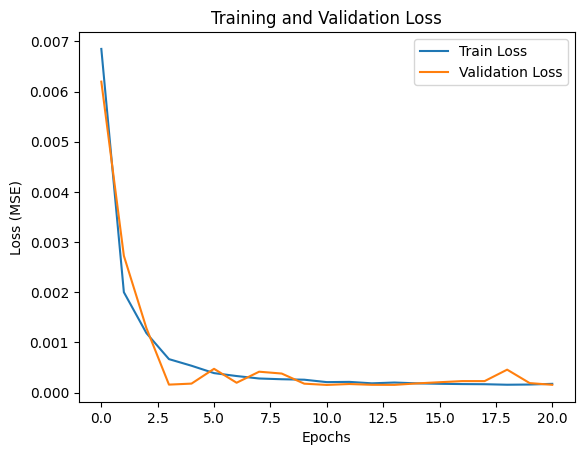

In [52]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# Example: Predict for a specific validation sequence
sequence_index = 170  # Index in the validation set

# Extract the sequence and true target
val_sequence = X_val[sequence_index]
true_target = y_val[sequence_index]

# Reshape for prediction
val_sequence = val_sequence.reshape(1, val_sequence.shape[0], val_sequence.shape[1])  # Shape: (1, 30, num_features)

# Predict
predicted_target = model.predict(val_sequence)

print(f"Validation Input Sequence (30 days):\n{X_val[sequence_index]}")
print(f"True Target (Day {sequence_index + 1}'s Daily_Return): {true_target}")
print(f"Predicted Target: {predicted_target[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Validation Input Sequence (30 days):
[[ 1.74366538  1.74891756  1.74549498  1.71962973 -0.72343026]
 [ 1.72956675  1.70979766  1.72796837  1.70950646 -0.63786721]
 [ 1.7204828   1.7093273   1.71615703  1.72426549 -0.61207703]
 [ 1.76183271  1.77148666  1.78321529  1.79351961 -0.65145281]
 [ 1.8154837   1.80534045  1.83570007  1.82540292 -0.70865787]
 [ 1.80810317  1.81747116  1.82788922  1.83789142 -0.76687568]
 [ 1.85494134  1.84718725  1.87551597  1.87053176 -0.98577001]
 [ 1.87585279  1.86618314  1.90161563  1.88727752 -0.94873042]
 [ 1.88190847  1.8765271   1.90447312  1.89844135 -1.0676432 ]
 [ 1.89477726  1.88442656  1.90199644  1.8939947  -0.81532721]
 [ 1.90565877  1.89599307  1.91476066  1.9169847  -1.01140914]
 [ 1.93328862  1.92034891  1.94495586  1.92086372 -0.85517483]
 [ 1.92619194  1.90784197  1.92876265  1.90175274 -0.61978762]
 [ 1.91682414  1.9195026   1.94390822  1.94319168 -0.92188291]
 [ 1.92070369  1.93041106  1.94495586  1.95

In [57]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for pred_return, true_return in zip(y_pred, y_true):
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    daily_return = true_return if position == 1 else 0
    strategy_returns.append(daily_return)

    # Update cumulative return
    cumulative_return *= (1 + daily_return)

# Convert strategy returns to a DataFrame for analysis
strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Cumulative Return: 22.94%
